Challenge: ccv1  
# Deep Learning: Was versteckt sich da?  
## Demo Modell
In diesem Notebook können Bilder mit unterschiedlichen Megadetector Threshold mit dem Modell getestet werden.

In [1]:
import os
print(os.getcwd())
if os.getcwd().endswith("demo"):
    os.chdir("..")
import ast
import PIL
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms
from src.evaluation import Animal
from torchvision import models
from torch import nn
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from src.augmentation import CCV1Transformer,None_Transform
from src import modelling
os.chdir("demo")

c:\Users\j\gitlab\tierli_ahluege\demo


## Test Bild
Bilder werden zufällig aus dem `demo_images` Ordner geladen. Es können auch weitere Bilder geladen werden. Zudem sind die Bilder mit high, low und mid beschriftet. Dies zeigt das jeweilige Confidenceintervall an.

In [2]:
def get_image(visualize:bool=True,seed:int=None):
    random.seed(seed)

    folder_path = './demo_images'
    images = os.listdir(folder_path)

    random_image_name = random.choice(images)
    random_image_path = os.path.join(folder_path, random_image_name)
    random_image = Image.open(random_image_path)
    if visualize:
        display(random_image_name[:-4])
        display(random_image)
    return random_image

## Klasse Demo Modell
Die Demo Klasse wird verwendet, um alle Berechnungschritte durchzuführen.

In [9]:
class demo():
    def __init__(self) -> None:
        self.transformer = demo.preprocessing()
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.high_models = [self.prep_model(f"../model_submit/convnext_tiny_megadetector_ensemble_range_high_lr_1e-4_cv_bs_32{fold}.pth")for fold in range(4)]
        self.mid_models = [self.prep_model(f"../model_submit/convnext_tiny_megadetector_ensemble_range_mid_lr_1e-4_cv_bs_32{fold}.pth")for fold in range(4)]
        self.low_models = [self.prep_model(f"../model_submit/convnext_tiny_megadetector_ensemble_range_low_cv_lr_1e-4_bs_32{fold}.pth")for fold in range(4)]

    def pred_image(self,mega_range:str,image:PIL,visualize_output:bool=True):
        image_prep = self.transformer(image).to(self.device)
        preds = 0
        if mega_range=="high":
            for model in self.high_models:
                preds = np.add(preds,self.predict_model(self.device).predict(model=model.to(self.device),data_loader=[{"image":image_prep.view(1,3, 224, 224).to(self.device)}])[0])
            preds /= len(self.high_models)
        elif mega_range=="medium":
            for model in self.mid_models:
                preds = np.add(preds,self.predict_model(self.device).predict(model=model.to(self.device),data_loader=[{"image":image_prep.view(1,3, 224, 224).to(self.device)}])[0])
            preds /= len(self.mid_models)
        elif mega_range=="low":
            for model in self.low_models:
                preds += np.add(preds,self.predict_model(self.device).predict(model=model.to(self.device),data_loader=[{"image":image_prep.view(1,3, 224, 224).to(self.device)}])[0])
            preds /= len(self.low_models)
        else:
            print("possible mega ranges are: 'high','medium','low'")
            raise ValueError
        preds = torch.softmax(torch.from_numpy(preds), dim=1)
        if visualize_output:
            plt.imshow(image)
            plt.title(F"{list(Animal)[preds.argmax()].value}: {np.array(preds.max()).round(4)}" )
            plt.show()
        else:
            for x in range(8):
                print(F"{list(Animal)[x]}: {np.array(preds[0][x]).round(4)}")
            return preds

    @staticmethod
    def preprocessing(pretrained_model:str="convnext"):
        model_transformer = CCV1Transformer(
            transforms.Compose([None_Transform()]), "model_specific", pretrained_model
        ).getCompose(True)
        return model_transformer
    
    @staticmethod
    def convnext_tiny_():
        model = models.convnext_tiny(weights=None,)
        model.classifier[2] =nn.Linear(in_features=768, out_features=8, bias=True)
        return model
    
    def prep_model(self,model_path:str):
        model =demo.convnext_tiny_()
        model.load_state_dict(torch.load(model_path,map_location=self.device))
        model.eval()
        return model.to(self.device)
    
    class predict_model(modelling.CCV1_Trainer):
        def __init__(self,device):
            self.device = device

## Beispiele Demo Klasse
Zuerst muss die Klasse instanziert werden. Danach können vorhersagen anhand des Confidenceintervalls und das jeweilige Bild gemacht werden.

In [10]:
demo = demo()

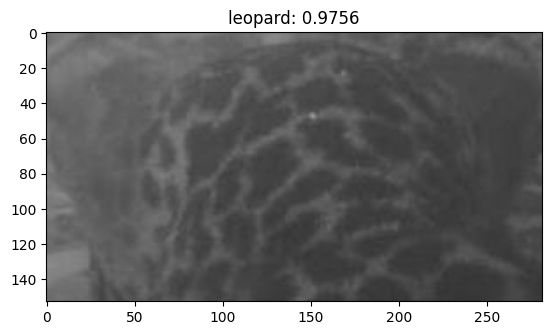

In [11]:
demo.pred_image("medium",get_image(visualize=False,seed=14))

In [12]:
preds = demo.pred_image("high",get_image(visualize=False,seed=14),visualize_output=False)

antelope_duiker: 0.0028
bird: 0.0004
blank: 0.0018
civet_genet: 0.024
hog: 0.0009
leopard: 0.9694
monkey_prosimian: 0.0006
rodent: 0.0002


## Vorbereitung für weitere Vorhersagen

'image_low_th_5_ZJ018364'

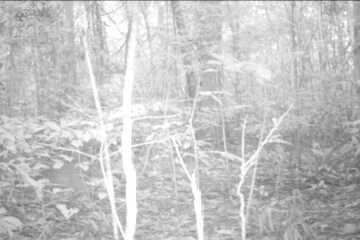

In [13]:
image = get_image(visualize=True,seed=12)

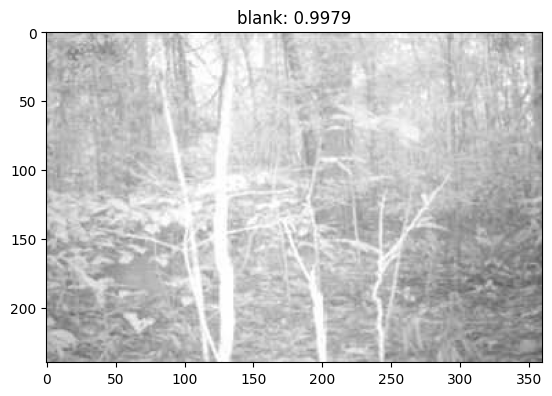

In [14]:
demo.pred_image("low",image)